In [ ]:
import sys
from pathlib import Path
sys.path.append(Path.cwd().parent.as_posix())


In [30]:
output_dir = Path.cwd().parent / "output"
curation_result_paths = {
    "only_post_processing": (output_dir / "extraction_results" / "post_processing_enhancement" /
        "extraction_results_2025-03-10" / "curation_result_extracted_statements_2025-03-10.pkl"),
    "with statement_type_correction": (output_dir / "extraction_results" / "statement_type_correction_refinement" /
        "extraction_results_2025-03-11" / "curation_result_extracted_statements_2025-03-11.pkl"),
    "with_error_context_and_statement_type_correction": (output_dir / "extraction_results" / "errors_context_provided" / 
        "extraction_results_2025-03-11-02" / "curation_result_extracted_statements_2025-03-11-02.pkl"),
}
source_extraction_paths = {
    "only_post_processing": (output_dir / "extraction_results" / "post_processing_enhancement" /
        "extraction_results_2025-03-10" / "detailed_extraction_results_2025-03-10.pkl"),
    "with statement_type_correction": (output_dir / "extraction_results" / "statement_type_correction_refinement" /
        "extraction_results_2025-03-11" / "detailed_extraction_results_2025-03-11.pkl"),
    "with_error_context_and_statement_type_correction": (output_dir / "extraction_results" / "errors_context_provided" / 
        "extraction_results_2025-03-11-02" / "detailed_extraction_results_2025-03-11-02.pkl"),
}


In [ ]:
import pickle
df_only_post_processing = pickle.load(open(curation_result_paths["only_post_processing"], "rb"))
df_with_statement_type_correction = pickle.load(open(curation_result_paths["with statement_type_correction"], "rb"))
df_with_error_context_and_statement_type_correction = pickle.load(open(curation_result_paths["with_error_context_and_statement_type_correction"], "rb"))

extraction_results_only_post_processing = pickle.load(open(source_extraction_paths["only_post_processing"], "rb"))
extraction_results_with_statement_type_correction = pickle.load(open(source_extraction_paths["with statement_type_correction"], "rb"))
extraction_results_with_error_context_and_statement_type_correction = pickle.load(open(source_extraction_paths["with_error_context_and_statement_type_correction"], "rb"))


In [ ]:
def get_accuracy(df):
    count_correct_statements = len(df[df['num_correct_curation_tags'] > 0])
    count_total_statements = len(df)
    return count_correct_statements / count_total_statements


## Accuracy of the curations of 3 extraction samples

In [47]:
accuracy_only_post_processing = get_accuracy(df_only_post_processing)
accuracy_with_statement_type_correction = get_accuracy(df_with_statement_type_correction)
accuracy_with_error_context_and_statement_type_correction = get_accuracy(df_with_error_context_and_statement_type_correction)
print(f"Accuracy only post-processing: {accuracy_only_post_processing:.2f}")
print(f"Accuracy with statement type correction: {accuracy_with_statement_type_correction:.2f}")
print(f"Accuracy with error context and statement type correction: {accuracy_with_error_context_and_statement_type_correction:.2f}")
print(f"Average accuracy over all three curation results: {((accuracy_only_post_processing + accuracy_with_statement_type_correction + accuracy_with_error_context_and_statement_type_correction) / 3):.2f}")


Accuracy only post-processing: 0.62
Accuracy with statement type correction: 0.59
Accuracy with error context and statement type correction: 0.61
Average accuracy over all three curation results: 0.61


## Statements yield. I.e. how many statements were extracted in total given n input texts?

In [103]:
print(f"Yield only post-processing: {len(df_only_post_processing)} statements from {len(extraction_results_only_post_processing['raw_input_data'])} input sentences")
print(f"Yield with statement type correction: {len(df_with_statement_type_correction)} statements from {len(extraction_results_with_statement_type_correction['raw_input_data'])} input sentences")
print(f"Yield with error context and statement type correction: {len(df_with_error_context_and_statement_type_correction)} statements from {len(extraction_results_with_error_context_and_statement_type_correction['raw_input_data'])} input sentences")
print(f"Average yield over all three curation results: {((len(df_only_post_processing) + len(df_with_statement_type_correction) + len(df_with_error_context_and_statement_type_correction)) / 3):.2f} statements from {((len(extraction_results_only_post_processing['raw_input_data']) + len(extraction_results_with_statement_type_correction['raw_input_data']) + len(extraction_results_with_error_context_and_statement_type_correction['raw_input_data'])) / 3):.2f} input sentences")


Yield only post-processing: 71 statements from 100 input sentences
Yield with statement type correction: 46 statements from 100 input sentences
Yield with error context and statement type correction: 49 statements from 100 input sentences
Average yield over all three curation results: 55.33 statements from 100.00 input sentences


## Distribution of types of errors
1.	Filter incorrect statements: Select rows where num_correct_curation_tags == 0 and num_incorrect_curation_tags > 0.
2.	Extract the first incorrect curation tag: From extracted_stmt_curations, extract the first incorrect tag.
3.	Compute the frequency distribution: Count occurrences of each tag.

In [ ]:
from collections import OrderedDict, Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_first_incorrect_tag(curations_dict):
    if isinstance(curations_dict, dict) and curations_dict:
        ordered_curations = OrderedDict(curations_dict)  # Ensure ordering
        first_entry = next(iter(ordered_curations.values()))  # First inserted entry
        return first_entry.get("tag")  # Return the 'tag' field if available
    return None

def get_tag_distribution(df, tag_column="extracted_stmt_same_text_and_curated_evidence"):
    # Step 1: Filter incorrect statements
    incorrect_statements = df[
        (df["num_correct_curation_tags"] == 0) & 
        (df["num_incorrect_curation_tags"] > 0)
    ].copy()  # Avoid SettingWithCopyWarning

    # Step 2: Extract the first incorrect curation tag
    incorrect_statements.loc[:, "representative_tag"] = incorrect_statements[tag_column].apply(get_first_incorrect_tag)

    # Step 3: Compute the frequency distribution of tags
    tag_counts = Counter(incorrect_statements["representative_tag"].dropna())
    tag_distribution_df = pd.DataFrame(tag_counts.items(), columns=["Curation Tag", "Frequency"])

    return tag_distribution_df

def plot_tag_distribution(tag_distribution_df, df_name="Dataset"):
    # Fixed category order
    FIXED_CATEGORIES = [
        "entity_boundaries", "grounding", "no_relation", "wrong_relation", 
        "act_vs_amt", "polarity", "negative_result", "hypothesis", 
        "agent_conditions", "mod_site", "other"
    ]
    # Convert to relative frequencies (%)
    total_count = tag_distribution_df["Frequency"].sum()
    tag_distribution_df["Relative Frequency (%)"] = (tag_distribution_df["Frequency"] / total_count) * 100

    # Ensure all categories exist, filling missing ones with zero frequency
    tag_distribution_df = tag_distribution_df.set_index("Curation Tag").reindex(FIXED_CATEGORIES, fill_value=0).reset_index()

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=tag_distribution_df, x="Curation Tag", y="Relative Frequency (%)", order=FIXED_CATEGORIES)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Curation Tag")
    plt.ylabel("Relative Frequency (%)")
    plt.title(f"Relative Frequency Distribution of Incorrect Curation Tags in: {df_name}")
    plt.show()


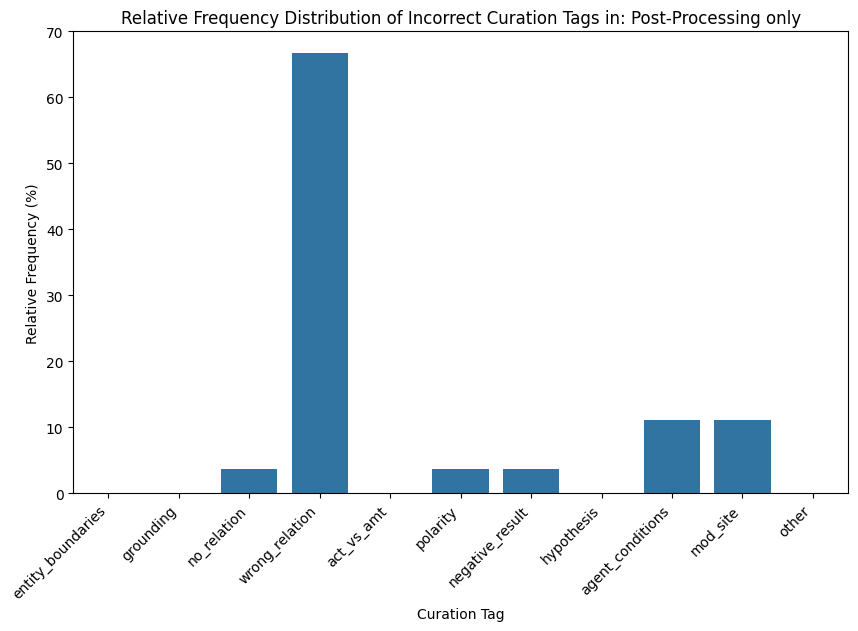

In [94]:
tag_distribution_df = get_tag_distribution(df_only_post_processing)
plot_tag_distribution(tag_distribution_df, df_name="Post-Processing only")


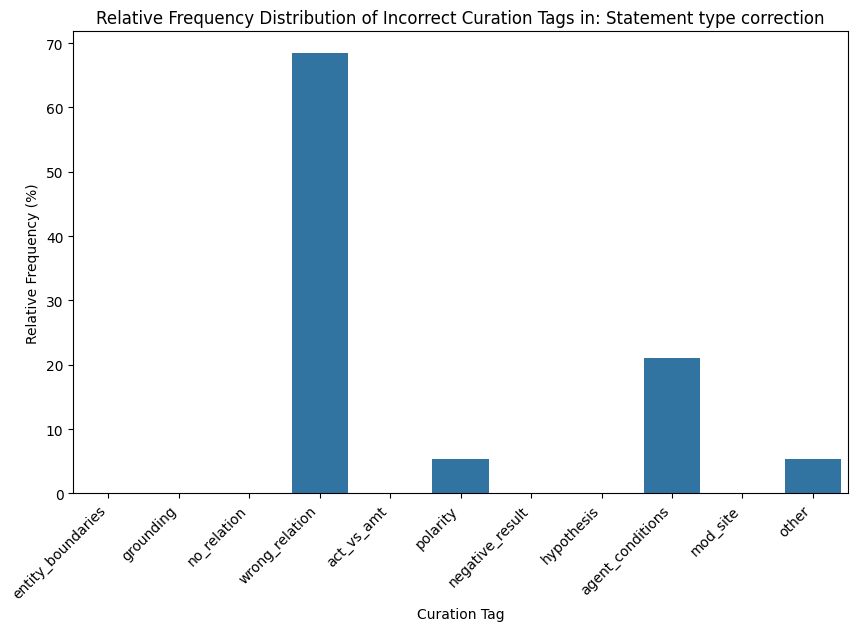

In [95]:
tag_distribution_df = get_tag_distribution(df_with_statement_type_correction)
plot_tag_distribution(tag_distribution_df, df_name="Statement type correction")


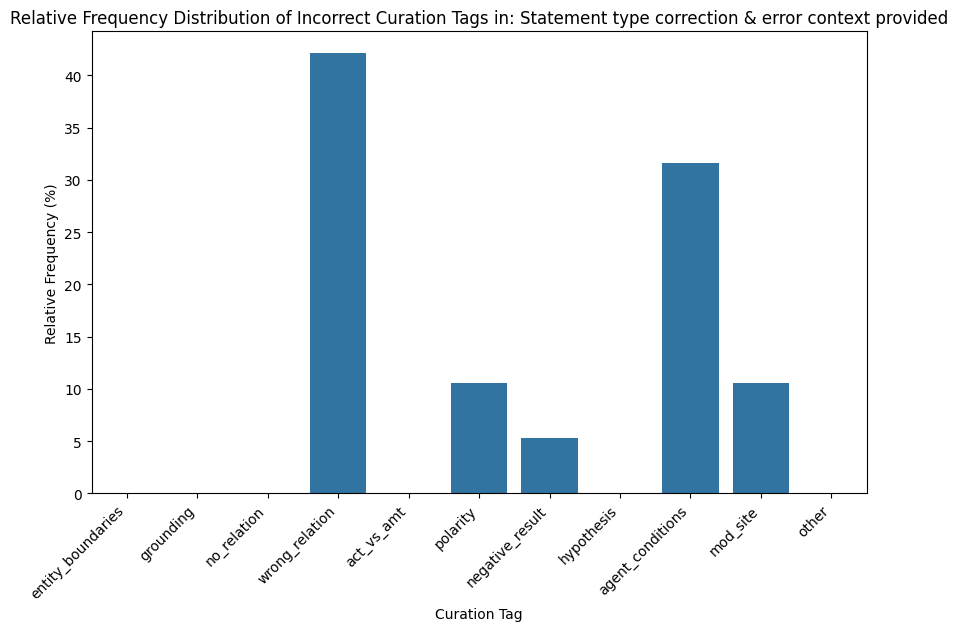

In [97]:
tag_distribution_df = get_tag_distribution(df_with_error_context_and_statement_type_correction)
plot_tag_distribution(tag_distribution_df, df_name="Statement type correction & error context provided")
